# Módulos

Importamos bibliotecas estándar para manipulación de datos (`pandas`, `numpy`), visualización (`matplotlib`, `seaborn`, `plotly`) y modelos/transformaciones de `scikit-learn`.

`imblearn.SMOTE` aparecerá más adelante para manejar el desbalance de clases y `xgboost` se usa como modelo avanzado basado en boosting. 

Las advertencias se silencian para mantener la salida limpia.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

import datetime

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_sample_weight

from imblearn.over_sampling import SMOTE # Aumentar clase minoritaria
from collections import Counter
import joblib


import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

# Lectura de Dataset

Cargamos el CSV del dataset de vino. 

Aquí verificamos rápidamente las primeras filas para entender columnas y tipos de datos. 

Es importante confirmar el separador `;` y cómo se tratan valores faltantes.

In [15]:
df = pd.read_csv('dataset_ml/wine_quality/winequality-red.csv', sep=';', na_values='?') # No hay datos nulos
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Mostrar `head()` nos permite confirmar columnas relevantes (`quality`, variables físico-químicas) y si hay registros extraños.

Esto guía las próximas gráficas y la selección de variables.

#  Gráficas

Empezamos el EDA visualizando relaciones entre variables clave. Después de cada gráfico se añadirá una interpretación corta para conectar la visualización con decisiones posteriores del modelado.

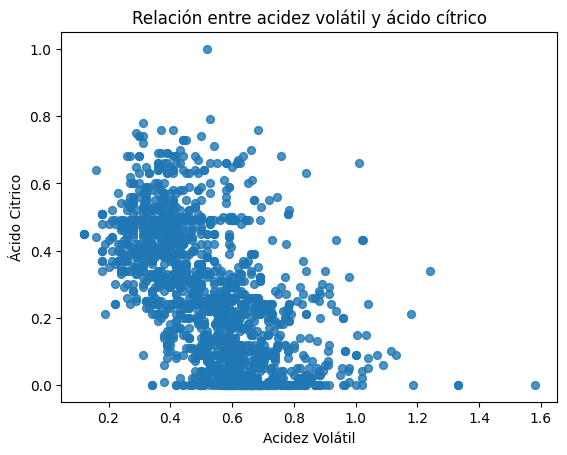

In [16]:
df.plot(kind='scatter', x='volatile acidity', y='citric acid', s=32, alpha=.8)
plt.xlabel('Acidez Volátil')
plt.ylabel('Ácido Citrico')
plt.title("Relación entre acidez volátil y ácido cítrico")
plt.show()

**Interpretación (EDA):** En este scatter observamos cómo varían `citric acid` y `volatile acidity`. 

Si existe una tendencia negativa, indicaría que mayor acidez volátil suele asociarse a menor ácido cítrico; esto puede ser informativo al seleccionar variables o detectar multicolinealidad.

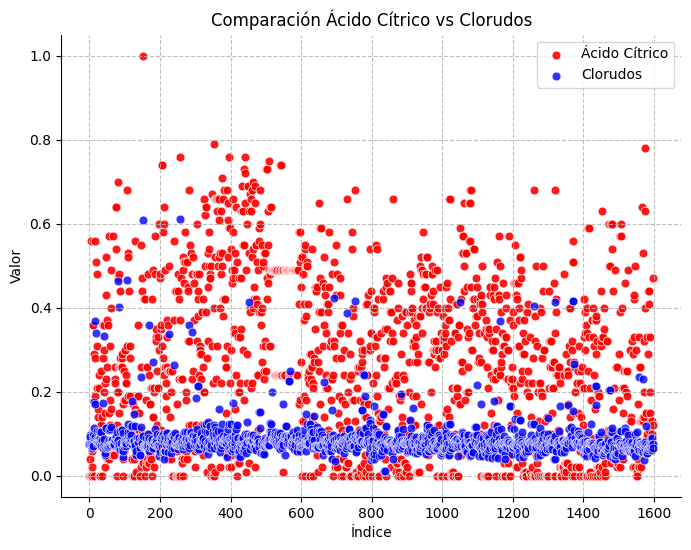

In [17]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df.index, y=df['citric acid'], color='red', label='Ácido Cítrico', s=40, alpha=0.9)
sns.scatterplot(x=df.index, y=df['chlorides'], color='blue', label='Clorudos', s=40, alpha=0.8)

plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Comparación Ácido Cítrico vs Clorudos')
plt.legend()
sns.despine() # Elimina los bordes superiores y derecho
plt.grid(True, linestyle='--', alpha=0.8) # Activa la cuadrícula usando lineas punteadas y con transparencia (alpha 0.8)
plt.show()

**Interpretación (EDA):** Este gráfico compara `citric acid` y `chlorides` a través del índice. Si los patrones son independientes, indica que estas variables aportan información distinta; si se mueven juntas, podría haber correlación que conviene evaluar con la matriz de correlación.

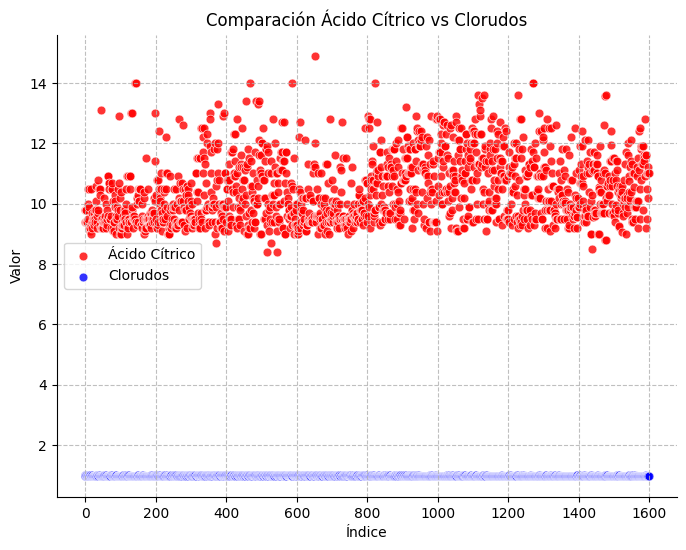

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df.index, y=df['alcohol'], color='red', label='Ácido Cítrico', s=40, alpha=0.8)
sns.scatterplot(x=df.index, y=df['density'], color='blue', label='Clorudos', s=40, alpha=0.8)

plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Comparación Ácido Cítrico vs Clorudos')
plt.legend()
sns.despine() # Elimina los bordes superiores y derecho
plt.grid(True, linestyle='--', alpha=0.8) # Activa la cuadrícula usando lineas punteadas y con transparencia (alpha 0.8)
plt.show()

**Interpretación (EDA):** Al comparar `alcohol` y `density` podemos detectar relaciones (normalmente `alcohol` tiende a estar inversamente relacionada con `density`). Esto ayuda a entender qué variables pueden ser predictoras fuertes de `quality`.

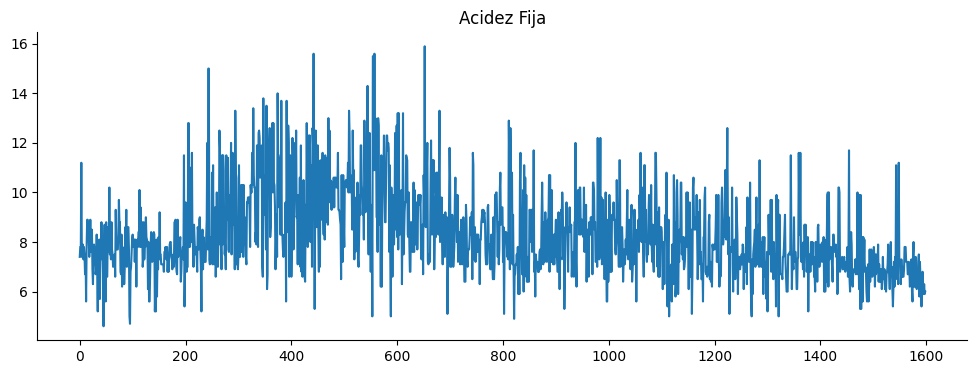

In [19]:
df['fixed acidity'].plot(kind='line', figsize=(12, 4), title='fixed acidity')
plt.title("Acidez Fija")  # Agrega esta línea
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

**Interpretación (EDA):** La serie temporal de `fixed acidity` muestra variaciones a lo largo del dataset; aquí buscamos outliers o patrones que puedan indicar propiedades del proceso de producción.

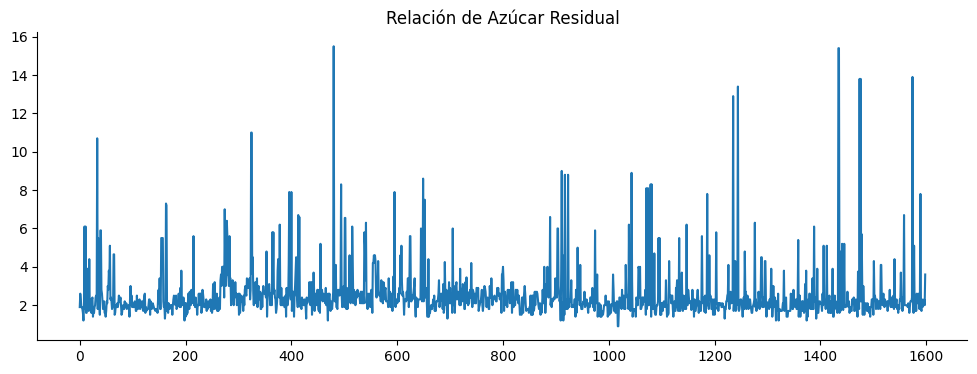

In [20]:
df['residual sugar'].plot(kind='line', figsize=(12, 4), title='residual sugar')
plt.title("Relación de Azúcar Residual")  # Agrega esta línea
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

**Interpretación (EDA):** La serie de `residual sugar` ayuda a detectar posibles sesgos en la concentración de azúcares; puede relacionarse con la percepción de calidad en algunos estilos de vino.

# Matriz de Correlación

**Por qué:** La matriz de correlación cuantifica relaciones lineales entre variables; es crucial para detectar variables predictoras fuertes y multicolinealidad. Después del heatmap añadiremos una interpretación con las relaciones más relevantes.

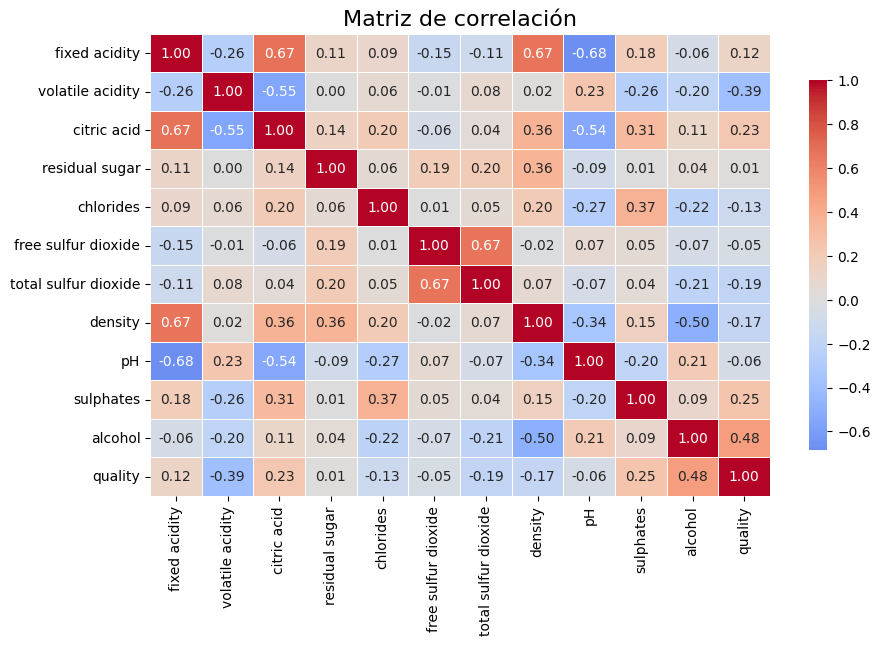

In [21]:
corr = df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr,
    annot=True,          # muestra los valores
    fmt=".2f",           # 2 decimales
    cmap="coolwarm",     # paleta de colores
    center=0,            # centra el color en 0
    linewidths=0.5,      # separadores
    cbar_kws={"shrink": .8}  # barra de color más pequeña
)
plt.title("Matriz de correlación", fontsize=16)
plt.show()

En la matriz de correlación, observa qué variables tienen mayor correlación con `quality` (por ejemplo `alcohol` suele ser positiva). Las variables con alta correlación absoluta merecen atención como features importantes.

# Separación de datos en train y test

Separa los datos en conjunto de entrenamiento y prueba usando `stratify=y` para mantener la misma distribución de clases en ambos conjuntos; esto es importante en problemas desbalanceados.

In [22]:
df.head(1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [23]:
df = df[['alcohol', 'volatile acidity', 'sulphates', 'citric acid', 'residual sugar', 'pH', 'quality']]
df.info(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   alcohol           1599 non-null   float64
 1   volatile acidity  1599 non-null   float64
 2   sulphates         1599 non-null   float64
 3   citric acid       1599 non-null   float64
 4   residual sugar    1599 non-null   float64
 5   pH                1599 non-null   float64
 6   quality           1599 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 87.6 KB


Seleccionamos un subconjunto de variables relevantes para simplificar el experimento y enfocarnos en características comúnmente usadas en datasets de calidad de vino.

`df.info()` confirma tipos de dato y ausencia de nulos.

In [24]:
x = df.drop('quality', axis=1)
y = df['quality']

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, stratify=y)

# Reagrupar Variables de Y (Puntuación Baja, Media, Alta)

Las puntuaciones originales de calidad están muy desbalanceadas. Para convertirlo en un problema de clasificación más manejable y con mayor impacto práctico, he agrupado las puntuaciones en tres categorías:

- 3 y 4 juntos → Clase "Baja"

- 5 solo → Clase "Media"

- 6, 7 y 8 juntos → Clase "Alta"

Agrupar reduce el número de clases y mitiga el efecto de clases con muy pocos ejemplos (p.ej. 3 o 8). Esto mejora la estabilidad del entrenamiento y hace la evaluación más interpretable para aplicaciones prácticas (baja/media/alta calidad). Si prefieres un problema de regresión o más clases, lo discutimos y lo adapto.

In [26]:
# Escalar solo con TRAIN
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [27]:
# Reagrupar etiquetas

def reagrupacion(y):
    y_new = []
    for val in y:
        if val in [3, 4]:
            y_new.append("0")
        elif val == 5:
            y_new.append("1")
        elif val in [6, 7, 8]:
            y_new.append("2")
    return np.array(y_new)

y_train_re = reagrupacion(y_train)
y_test_re  = reagrupacion(y_test)

y_train_re = y_train_re.astype(int)
y_test_re  = y_test_re.astype(int)

Uso SMOTE para evitar que el modelo se incline hacia la clase mayoritaria y mejore su capacidad de predecir las clases minoritarias, utilizo la técnica de sobremuestreo SMOTE en los datos de entrenamiento

SMOTE (Synthetic Minority Over-sampling Technique) genera ejemplos sintéticos de las clases minoritarias interpolando entre vecinos. Se usa para que el modelo no se sesgue hacia la clase mayoritaria y mejore la detección de clases minoritarias sin duplicar ejemplos exactamente.

In [28]:
print("Distribución original:", Counter(y_train_re))

# Definimos que solo la clase 0 suba a 600 ejemplos
smote = SMOTE(sampling_strategy={0: 650}, random_state=42)
x_train_res, y_train_res = smote.fit_resample(x_train_scaled, y_train_re)


print("Distribución después de SMOTE:", Counter(y_train_res))

Distribución original: Counter({np.int64(2): 684, np.int64(1): 545, np.int64(0): 50})
Distribución después de SMOTE: Counter({np.int64(2): 684, np.int64(0): 650, np.int64(1): 545})


# Modelo Random Forest Classifier

**Por qué:** Entrenamos un Random Forest con `class_weight='balanced'` y parámetros conservadores para comparación rápida. Random Forest es un buen baseline porque maneja no linealidades y es robusto a features irrelevantes.

In [29]:
rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=5,
        n_jobs=1,
        class_weight="balanced",
        random_state=42
)

rf.fit(x_train_res, y_train_res)
y_pred = rf.predict(x_test_scaled)

score = rf.score(x_train_res, y_train_res)

print(score)
print(classification_report(y_test_re, y_pred, target_names=['Bajo', 'Medio', 'Alto']))

0.7748802554550293
              precision    recall  f1-score   support

        Bajo       0.16      0.69      0.26        13
       Medio       0.67      0.57      0.61       136
        Alto       0.80      0.69      0.74       171

    accuracy                           0.64       320
   macro avg       0.54      0.65      0.54       320
weighted avg       0.72      0.64      0.67       320



**Interpretación (Modelo):** Revisa el `classification_report` para ver precisión, recall y F1 por clase. Observa si el modelo se comporta mejor en alguna clase (p. ej. la mayoritaria).

### Matriz de Confusion

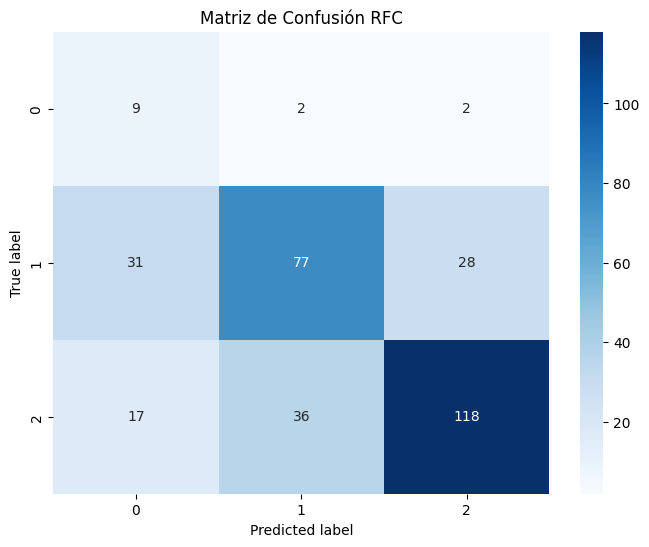

In [30]:
cm = confusion_matrix(y_test_re, rf.predict(x_test_scaled))

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=np.unique(y_test_re),
    yticklabels=np.unique(y_test_re)
)

plt.title("Matriz de Confusión RFC")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

**Interpretación (Matriz de Confusión):** La matriz muestra dónde el modelo confunde clases (p. ej. predecir `Medio` cuando es `Alto`). Evalúa modelos adicionales si hay confusiones sistemáticas.

# Modelo XGBoost
#### Modelo basado en árboles de decisión (gradient boosting trees)

XGBoost es un modelo de boosting potente que suele rendir bien en tabulares; aquí se entrena con weights balanceados para mejorar el rendimiento en clases minoritarias.

In [31]:
"""
param_grid = {
    'n_estimators': [500, 1000, 2000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

xgb_model_base = xgb.XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

grid_search = GridSearchCV(
    estimator=xgb_model_base,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    n_jobs=-1
 )

print("Iniciando búsqueda de hiperparámetros...", datetime.datetime.now())
grid_search.fit(x_train_res, y_train_res)
print(grid_search.best_params_)
"""

# Parametros devueltos por GridSearch:
# {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}

'\nparam_grid = {\n    \'n_estimators\': [500, 1000, 2000],\n    \'learning_rate\': [0.01, 0.05, 0.1],\n    \'max_depth\': [3, 5, 7],\n    \'subsample\': [0.8, 0.9],\n    \'colsample_bytree\': [0.8, 0.9]\n}\n\nxgb_model_base = xgb.XGBClassifier(\n    objective="multi:softprob",\n    eval_metric="mlogloss",\n    random_state=42,\n    n_jobs=-1\n)\n\ngrid_search = GridSearchCV(\n    estimator=xgb_model_base,\n    param_grid=param_grid,\n    scoring=\'f1_weighted\',\n    cv=3,\n    verbose=2,\n    n_jobs=-1\n )\n\nprint("Iniciando búsqueda de hiperparámetros...", datetime.datetime.now())\ngrid_search.fit(x_train_res, y_train_res)\nprint(grid_search.best_params_)\n'

In [32]:

weights = compute_sample_weight(class_weight="balanced", y=y_train_res)

xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    booster="gbtree",
    max_depth=7,
    subsample=0.8,                #      Muestreará aleatoriamente la mitad de los datos de entrenamiento antes de generar árboles, lo que evitará el sobreajuste.
    colsample_bytree=0.9,         #      Muestreo
    reg_lambda=0.8,               #      Aumentar este valor hará que el modelo sea más conservador.
    reg_alpha=0.9,                #      Regularización (evitar sobreajuste).
    objective="multi:softprob",   #      Multiclase
    evaL_metrics="mlogloss",      #      Pérdida Logarítmica multiclase
    tree_method="exact",          #     Algoritmo de construcción de árboles utilizado en XGBoost. Algoritmo voraz exacto. Enumera todos los candidatos divididos.
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(x_train_res, y_train_res, sample_weight=weights)

# ---
y_pred_xgb = xgb_model.predict(x_test_scaled)

accuracy_xgb = accuracy_score(y_test_re, y_pred_xgb)

print("Precisión:", accuracy_xgb)

print(classification_report(y_test_re, y_pred_xgb, target_names=["Bajo", "Medio", "Alto"]))

Precisión: 0.765625
              precision    recall  f1-score   support

        Bajo       0.50      0.54      0.52        13
       Medio       0.75      0.74      0.74       136
        Alto       0.80      0.81      0.80       171

    accuracy                           0.77       320
   macro avg       0.68      0.69      0.69       320
weighted avg       0.77      0.77      0.77       320



### Interpretación de XGBoost y pasos siguientes
En esta sección se resumen los resultados obtenidos con XGBoost y se proponen acciones prácticas para mejorar la detección de clases (especialmente reducir falsos negativos).

Puntos clave:
- Compara el `classification_report` de XGBoost con el de RandomForest: fija la métrica que priorizas (recall para minimizar falsos negativos, o F1 ponderado para equilibrio).
- Si una clase (por ejemplo `Alto`) tiene bajo recall, considera:
  - ajustar el umbral (ver celda de calibración/umbral abajo),
  - aumentar el muestreo sintético de esa clase con `SMOTE` o combinar con undersampling,
  - añadir features o transformar las existentes para mejor separación.
- Usa validación por particiones o `GridSearchCV` con `scoring` orientado a recall/F1 por clase para seleccionar hiperparámetros.
- Si necesitas probabilidades bien calibradas (p. ej. para decidir umbrales), usa `CalibratedClassifierCV` o `sklearn` calibration methods.

Siguientes artefactos en el notebook:
- Gráfico de importancia de features para entender qué variables lideran la predicción (celda siguiente).
- Ejemplo de calibración y ajuste de umbral (celda después).
- Código para guardar modelos y el `scaler`.

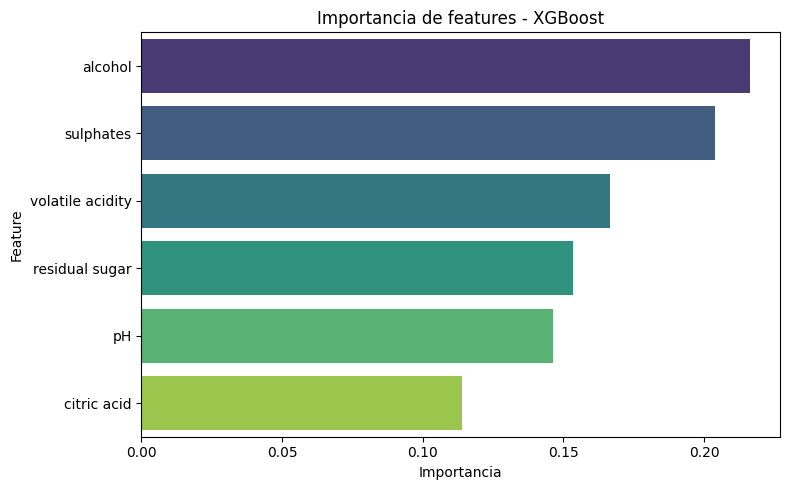

In [33]:
# Importancia de features del modelo XGBoost
importances = xgb_model.feature_importances_
feat_names = x.columns if hasattr(x, 'columns') else [f'feat_{i}' for i in range(len(importances))]
imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances})
imp_df = imp_df.sort_values(by='importance', ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(data=imp_df, x='importance', y='feature', palette='viridis')
plt.title('Importancia de features - XGBoost')
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Guardamos modelo

In [34]:
xgb_model.save_model('modelos/ml/wine_quality/xgb_model.json')

**Interpretación (XGBoost):** Revisa el `classification_report` y compara métricas con Random Forest. Observa especialmente el F1 por clase y la matriz de confusión para entender en qué clases mejora XGBoost.

### Matriz de Confusión

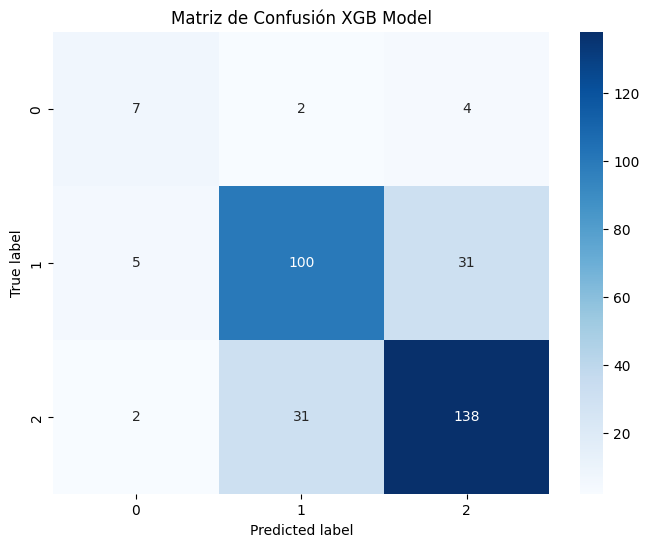

In [35]:
cm_xgb = confusion_matrix(y_test_re, xgb_model.predict(x_test_scaled))

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_xgb,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=np.unique(y_test_re),
    yticklabels=np.unique(y_test_re)
)

plt.title("Matriz de Confusión XGB Model")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Conclusiones

In [36]:
print("\nModelo XGBoost:\n")
print(classification_report(y_test_re, y_pred_xgb, target_names=["Bajo", "Medio", "Alto"]))
print("\nModelo Random Forest:\n")

print(classification_report(y_test_re, y_pred, target_names=['Bajo', 'Medio', 'Alto']))


Modelo XGBoost:

              precision    recall  f1-score   support

        Bajo       0.50      0.54      0.52        13
       Medio       0.75      0.74      0.74       136
        Alto       0.80      0.81      0.80       171

    accuracy                           0.77       320
   macro avg       0.68      0.69      0.69       320
weighted avg       0.77      0.77      0.77       320


Modelo Random Forest:

              precision    recall  f1-score   support

        Bajo       0.16      0.69      0.26        13
       Medio       0.67      0.57      0.61       136
        Alto       0.80      0.69      0.74       171

    accuracy                           0.64       320
   macro avg       0.54      0.65      0.54       320
weighted avg       0.72      0.64      0.67       320



Conclusión basada en los resultados aportados

- Resumen numérico:
  - XGBoost: accuracy 0.77, weighted F1 ~0.76.  
  - Random Forest: accuracy 0.68, weighted F1 ~0.70.
- Interpretación por clase:
  - Clase "Alto": XGBoost muy bueno (precision 0.80, recall 0.82, f1 0.81). Ideal para identificar combinaciones que probablemente den vino de alta calidad.
  - Clase "Medio": ambos modelos razonables; XGBoost ligeramente mejor (f1 0.75 vs 0.68).
  - Clase "Bajo": ambos fallan (especialmente XGBoost en precision vs recall trade-off). Soporte muy bajo (13 muestras) — métricas poco fiables.

- Recomendación práctica para el enólogo:
  - Usar XGBoost como modelo principal para explorar recetas y ver probabilidades de "Alto" (mejor rendimiento en esa clase).
  - Mostrar siempre predict_proba al usuario para que valore la incertidumbre antes de decidir probar una receta.
- Riesgos y precauciones:
  - Las predicciones de "Bajo" son poco fiables por poco soporte; evita decisiones críticas basadas sólo en esa etiqueta.
  - Validar con pruebas reales en bodega antes de invertir en lotes grandes.
- Pasos siguientes recomendados:
  - Recolectar más ejemplos de vinos “Bajo” o equilibrar mejor el set (SMOTE/undersampling combinado) si interesa mejorar detección de la clase baja.
  - Si el enólogo necesita probabilidades interpretables para decisiones automáticas, considerar calibración posterior.
  - Versionar y exponer: modelo XGBoost + scaler + features.json y una interfaz que devuelva probabilidades y etiqueta argmax.

Conclusión corta: XGBoost es la mejor opción actual para buscar recetas que produzcan "Alto", mostrar probabilidades al enólogo y tomar decisiones experimentales; mejorar la clase "Bajo" requiere más datos o estrategias de muestreo.

- Apto como herramienta de apoyo a decisión (decision-support) en producción.
- No listo para automatizar decisiones críticas sin mejoras y controles.

En el siguiente release mejorare el modelo y haré una api para poder hacer peticiones y probar el modelo fácilmente.